This notebook is meant to run a single PVLT system using 12 different models found in pvlib-python and pvpltools-python

In [1]:
#Run a function file that has functions for importing sql data, simple filters, and visual dots
%run PVModel_Functions.py

In [133]:
#import packages used 
import datatools
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import median
from datetime import datetime
from pvpltools import iec61853
from pvpltools.module_efficiency import adr,heydenreich,motherpv,pvgis,mpm5,mpm6,bilinear,fit_efficiency_model,fit_bilinear 
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import figure
register_matplotlib_converters()
#setting plotting preferences
sns.set_context("poster", font_scale=.75) 
mpl.rcParams['axes.titlesize']=22
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
q = 1.60218e-19  # Elementary charge in units of coulombs
kb = 1.38066e-23
t = 298.15

## Importing & Formatting System and Weather Data

In [3]:
#System Data from the Module Coefficients Spreadsheet

mod_name = 'MissionSolar' #'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar']
mod_info = pd.read_excel('module_coefficients_bhk.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']

#Selects the module previously specified from the imported file 
module = mod_info[mod_name]

#Defining the System & Met. data table names along with start and end dates to use to perfrom the sql search
systablename = module['table_name']
mettablename =  'dbo.SNLA_Met_DataOut'
start = module['start']
end = module['end']

In [4]:
#Import sys & met using sql & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

#### Calculating Solar Position & Irradiance Conditions

In [5]:
#Calculate Solar Positions & Extraterrestrial DNI

#inputs into this cell: pressure(mBar), time, latitude, longitude, amb temp, altitude
#outputs of this cell: pressure(Pa), elevation, azimuth, zenith, apparent elevation, apparent zenith, dni extra

pres = df['Pressure_mBar_Avg']*100
sdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['latitude'], 
        longitude=module['longitude'],temperature=df['Temp_C_Avg'], altitude=module['altitude'])
sdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)

In [6]:
#Calculate Environmental Conditions

#inputs into this cell: module tilt, module azimuth, solar zenith, solar azimuth, DNI, DHI, GHI, DNI extra, 
#                       transp. model, pressure 
#outputs of this cell: poa global, poa direct, poa diffuse, poa sky diffuse, poa ground diffuse, aoi, 
#                       absolute airmass, relative airmass

edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['tilt'], surface_azimuth=module['surface_azimuth'], 
        solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'],dni=df['Direct_Wm2_Avg'],
        ghi=df['Global_Wm2_Avg'], dhi=df['Diffuse_Wm2_Avg'], dni_extra=sdf['dni_extra'], model ='haydavies')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['tilt'], surface_azimuth=module['surface_azimuth'], 
        solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)

In [7]:
#Calculate Effective Irradiance

#inputs into this cell: reference thetas, reference iams, aoi, poa direct, poa diffuse, module frac diff.
#outputs of this cell: aoi loss coefficients, effective irradiance

ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
F2 = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['eff_irr'] = (edf['poa_direct'] * F2 + module['FD'] * edf['poa_diffuse'])


# Applying Filters to Data
Parameters filtered include: <br>
Effective Irradiance (>50, <1200), <br>
Solar Elevation (>15, <90), <br>
Ambient Temperature (>-10, <40), <br>
Module/Cell Temperature (>-40, 85), <br>
Current to Irradiance Ratio (>70%, <130%),<br>
& some individual days which caused outliers due to pole shading, snow, etc

In [8]:
#Effective Irradiance
df = simple_filter(sys=df, variable='eff_irr', lower=50, upper=1200, apply=True)
#Solar Elevation
sol_elev_mask = simple_filter(sdf, 'apparent_elevation', lower=15, upper=90, apply=False)
df = df.where(sol_elev_mask, np.nan)
#Ambient Temperature
df = simple_filter(sys=df, variable='Temp_C_Avg', lower=-10, upper=40, apply=True)

In [9]:
#Not all systems measure BOM on the same strings, some have all strings, others have it on str 2&3, or str 1&4

#Measured String RTD is first filtered & then the average of all availble RTDs is taken
all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
twth_rtd = ['HanQPlus', 'HanQPeak']
onfo_rtd = ['Can 270', 'Can275']
tmp = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

if mod_name in all_rtd:
    df = simple_filter(sys=df, variable=module['str_1_rtd'], lower=-40, upper=85, apply=True)
    df = simple_filter(sys=df, variable=module['str_2_rtd'], lower=-40, upper=85, apply=True)
    df = simple_filter(sys=df, variable=module['str_3_rtd'], lower=-40, upper=85, apply=True)
    df = simple_filter(sys=df, variable=module['str_4_rtd'], lower=-40, upper=85, apply=True)

    df['mod_temp'] = ((df[module['str_1_rtd']]+df[module['str_2_rtd']]+df[module['str_3_rtd']]+df[module['str_4_rtd']])/4)

elif mod_name in twth_rtd:
    df = simple_filter(sys=df, variable=module['str_2_rtd'], lower=-40, upper=85, apply=True)
    df = simple_filter(sys=df, variable=module['str_3_rtd'], lower=-40, upper=85, apply=True)

    df['mod_temp'] = ((df[module['str_2_rtd']]+df[module['str_3_rtd']])/2)

else:
    df = simple_filter(sys=df, variable=module['str_1_rtd'], lower=-40, upper=85, apply=True)
    df = simple_filter(sys=df, variable=module['str_4_rtd'], lower=-40, upper=85, apply=True)

    df['mod_temp'] = ((df[module['str_1_rtd']]+df[module['str_4_rtd']])/2)

#Use the Average RTD value to calculate the cell temperature                              
df['cell_temp'] = pvlib.temperature.sapm_cell_from_module(module_temperature=df['mod_temp'], poa_global=edf['poa_global'], deltaT = tmp['deltaT'] )                  
df = simple_filter(sys=df,variable='cell_temp', lower=-40, upper=85, apply=True)

In [10]:
#Current to Irradiance Filter
string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'

for string_i in string_is:
    #Calculate the ratio at each given timestep
    df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr']
    #Create a df with no NaNs to calculate the slope of trendline between current and irradiance
    nadf = df.dropna(inplace=False)
    z = np.polyfit(nadf['eff_irr'], nadf[module[string_i]],1)
    #Calculate lower/upper bounds
    lower = z[0]-(z[0]*0.3)
    upper = (z[0]*0.3) + z[0]
    #Use previously defined column name to filter values
    ratio_name ='ratio' + ' ' + string_i + ' ' 'to eff_irr'
    df = simple_filter(df, ratio_name, lower=lower, upper=upper, apply=True)  

In [11]:
#Removing individual days that cause large errors due to shading, snow, etc

#filter out pole shading 
shade_list = ['Can270', 'HanQPlus']
if mod_name in shade_list:
    shade_start = '2020-10-06 00:00:00-07:00'
    shade_end = '2020-11-02 00:00:00-07:00'
    shask = (df.index > shade_start) & (df.index <= shade_end)
    df = df.loc[~shask]

#Filtering out days in 2019 that caused large outliers - could be due to snow on modules    
dec_list = ['Panasonic', 'LG']
if mod_name in dec_list:
    dec_start = '2019-12-29 00:00:00-07:00'
    dec_end = '2019-12-30 00:0:00-07:00'
    dec_mask = (df.index > dec_start) & (df.index <= dec_end)
    df = df.loc[~dec_mask]

# Performance Models

In [227]:
#Generate a results dataframe calculate the measured dc power for each string
results = []
str_1 = df[module['str_1_v']]*df[module['str_1_i']]
str_2 = df[module['str_2_v']]*df[module['str_2_i']]
str_3 = df[module['str_3_v']]*df[module['str_3_i']]
str_4 = df[module['str_4_v']]*df[module['str_4_i']]

### SAPM - considers Effective Irradiance, Cell Temperature, Module Dictionary
Module dictionary coefficients are calculated from CFV data (ask Bruce later)

In [202]:
#Run SAPM and calculate string power
dc = pvlib.pvsystem.sapm(effective_irradiance=df['eff_irr'], temp_cell=df['cell_temp'], module=module)
sapm_results = (dc['v_mp']*dc['i_mp']*module['str_len']).to_frame()

In [203]:
#Organize model results and other metrics that can be used for comparison
sapm_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
sapm_results['Str_1'] = str_1
sapm_results['Str_2'] = str_2
sapm_results['Str_3'] = str_3
sapm_results['Str_4'] = str_4
sapm_results['Irradiance'] = df['eff_irr']
sapm_results['Cell Temperature'] = df['cell_temp']
sapm_results['Sol Elev'] = sdf['apparent_elevation']
sapm_results['Sol Azim'] = sdf['azimuth']
sapm_results['Time'] = sapm_results.index
sapm_results['Year'] = sapm_results.index.year
sapm_results['Model Name'] = 'SAPM'
sapm_results['System'] = mod_name
results.append(sapm_results)

### PVWatts - considers Effective Irradiance, Cell Temperature, Rated Power, Temperature Coeff. of Power
Rated Power and Temperature Coeff of Power is sourced from CFV PAN Files

In [51]:
#Run PVW and calculate string power
pvw_pdc = pvlib.pvsystem.pvwatts_dc(g_poa_effective = df['eff_irr'], temp_cell = df['cell_temp'], 
            pdc0 = (module['p_mp']/module['gain_pmp']),gamma_pdc = (module['gamma_pmp']/100))
pvw_results = (pvw_pdc*module['str_len']).to_frame()

In [52]:
#Organize model results and other metrics that can be used for comparison
pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
pvw_results['Str_1'] = str_1
pvw_results['Str_2'] = str_2
pvw_results['Str_3'] = str_3
pvw_results['Str_4'] = str_4
pvw_results['Irradiance'] = df['eff_irr']
pvw_results['Module Temperature'] = df['cell_temp']
pvw_results['Sol Elev'] = sdf['apparent_elevation']
pvw_results['Sol Azim'] = sdf['azimuth']
pvw_results['Time'] = pvw_results.index
pvw_results['Year'] = pvw_results.index.year
pvw_results['Model Name'] = 'PVW'
pvw_results['System'] = mod_name
results.append(pvw_results)

##### Single Diode Model Coefficients (Rs, Rsh, Adjust, etc)
fit_cec_sam function is used to calculate the nec. coeffiencts. The input into fit_cec_sam is sourced from the CFV PAN files and the gain factors are applied so that the vmp, imp, isc, and voc are all unadjusted

In [114]:
cec_ivt = pvlib.ivtools.sdm.fit_cec_sam(celltype=module['cell_type'], v_mp=(module['v_mp']/module['gain_vmp']), 
                i_mp=(module['i_mp']/module['gain_imp']),v_oc=(module['v_oc']/module['gain_voc']),
                i_sc=(module['i_sc']/module['gain_isc']), alpha_sc=module['alpha_sc'], beta_voc=module['beta_voc'],
                gamma_pmp=module['gamma_pmp'], cells_in_series=module['Cells_in_Series'])
I_L_ref = cec_ivt[0]
I_o_ref = cec_ivt[1]
R_s = cec_ivt[2]
R_sh_ref = cec_ivt[3]
a_ref = cec_ivt[4]
Adjust = cec_ivt[5]
gamma_ref=(a_ref/module['Cells_in_Series'])*(q/(kb*t))

### CEC - considers Effective Irradiance, Cell Temperature, Temp. Coeff. of Isc, nNsVth, Photocurrent, Diode Reverse Sat. Current, Shunt Resistance, Series Resistance, Adjustment to Temp. Coeff. of Isc (Adjust)
The above coefficients at reference conditions come from the fit_cec_sam function and are used with the effective irradiance & cell temperature to calculate those parameters at every timestep. These are then used to calculate performance using the single diode model

In [210]:
#Calculate parameters necessary to input into single diode model
cec_param = pvlib.pvsystem.calcparams_cec(effective_irradiance=df['eff_irr'], temp_cell=df['cell_temp'], 
                        alpha_sc=module['alpha_sc'],a_ref=a_ref, I_L_ref=I_L_ref, I_o_ref=I_o_ref, R_sh_ref=R_sh_ref,
                        R_s=R_s,Adjust=Adjust,EgRef=1.121)
#Calculate power using single diode model
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], 
            resistance_series =cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
#Calculate string power
cec_results = (cec_p['p_mp']*module['str_len']).to_frame()

In [211]:
#Organize model results and other metrics that can be used for comparison
cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
cec_results['Str_1'] = str_1
cec_results['Str_2'] = str_2
cec_results['Str_3'] = str_3
cec_results['Str_4'] = str_4
cec_results['Irradiance'] = df['eff_irr']
cec_results['Module Temperature'] = df['cell_temp']
cec_results['Sol Elev'] = sdf['apparent_elevation']
cec_results['Sol Azim'] = sdf['azimuth']
cec_results['Time'] = cec_results.index
cec_results['Year'] = cec_results.index.year
cec_results['Model Name'] = 'CEC'
cec_results['System'] = mod_name
results.append(cec_results)

### Desoto - considers Effective Irradiance, Cell Temperature, Temp. Coeff. of Isc, nNsVth, Photocurrent, Diode Reverse Sat. Current, Shunt Resistance, Series Resistance
The above coefficients at reference conditions come from the fit_cec_sam function and are used with the effective irradiance & cell temperature to calculate those parameters at every timestep. These are then used to calculate performance using the single diode model

In [ ]:
#Calculate parameters necessary to input into single diode model
ds_param = pvlib.pvsystem.calcparams_desoto(effective_irradiance=df['eff_irr'],temp_cell=df['cell_temp'], 
        alpha_sc=module['alpha_sc'],a_ref=a_ref, I_L_ref=I_L_ref, I_o_ref=I_o_ref, R_sh_ref=R_sh_ref,R_s=R_s, EgRef=1.121)
#Calculate power using single diode model
ds_p = pvlib.pvsystem.singlediode(photocurrent=ds_param[0],saturation_current = ds_param[1],resistance_series=ds_param[2], 
                        resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
#Calculate string power
des_results = (ds_p['p_mp']*module['str_len']).to_frame()

In [ ]:
#Organize model results and other metrics that can be used for comparison
des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
des_results['Str_1'] = str_1
des_results['Str_2'] = str_2
des_results['Str_3'] = str_3
des_results['Str_4'] = str_4
des_results['Irradiance'] = df['eff_irr']
des_results['Module Temperature'] = df['cell_temp']
des_results['Time'] = des_results.index
des_results['Year'] = des_results.index.year
des_results['Model Name'] = 'DES'
des_results['System'] = mod_name
results.append(des_results)

### PVSyst - considers Effective Irradiance, Cell Temperature, Temp. Coeff. of Isc, Diode Ideality Factor (Gamma), Temp. Coeff of Gamma, Photocurrent, Diode Reverse Sat. Current, Shunt Resistance at Ref, Shunt Resistance at 0, Series Resistance, Exponent for Shunt Resistance, Cells in Series
The above coefficients at reference conditions come from the fit_cec_sam function and are used with the effective irradiance & cell temperature to calculate those parameters at every timestep. Parameters like Mu Gamma or Rsh0 that aren't calculated by fit_cec_sam are sourced from the CFV PAN files. These are then used to calculate performance using the single diode model

In [ ]:
#Calculate parameters necessary to input into single diode model
pvs_param = pvlib.pvsystem.calcparams_pvsyst(effective_irradiance=df['eff_irr'],temp_cell=df['cell_temp'], 
            alpha_sc=module['alpha_sc'],gamma_ref=gamma_ref,mu_gamma=module['mu_gamma'], I_L_ref=I_L_ref,I_o_ref=I_o_ref,
            R_sh_ref=R_sh_ref, R_sh_0=module['R_sh_0'],R_s=R_s,cells_in_series=module['Cells_in_Series'], EgRef=1.121)
#Calculate power using single diode model
pvs_p = pvlib.pvsystem.singlediode(photocurrent=pvs_param[0],saturation_current =pvs_param[1],resistance_series=pvs_param[2],
        resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
#Calculate string power
pvs_results = (pvs_p['p_mp']*module['str_len']).to_frame()

In [ ]:
#Organize model results and other metrics that can be used for comparison
pvs_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
pvs_results['Str_1'] = str_1
pvs_results['Str_2'] = str_2
pvs_results['Str_3'] = str_3
pvs_results['Str_4'] = str_4
pvs_results['Irradiance'] = df['eff_irr']
pvs_results['Module Temperature'] = df['cell_temp']
pvs_results['Time'] = pvs_results.index
pvs_results['Year'] = pvs_results.index.year
pvs_results['Model Name'] = 'PVS'
pvs_results['System'] = mod_name
results.append(pvs_results)

##### Matrix Data from 61853 - https://pvpmc.sandia.gov/download/7701/
Import measurements from module taken at different temperatures/irradiances. The 'rated' power here is taken to be the pan file power with the gain factor applied so it is undadjusted


In [153]:
#Import matrix of measurement data
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']
# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values
# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

### ADR - considers Effective Irradiance, Module Temperature, Optimized Parameters 
The Optimized Parameters are calculated using a non-linear least squares fit performed by scipy curve_fit on the imported matrix data. The output of the ADR performance model is normalized efficiency which is converted to power

In [ ]:
#Calculate ADR results and add to df
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=adr)
#Calculate eff. using adr model
adr_eff = adr(df['eff_irr'],df['mod_temp'],*popt)
#Calculate power given the above adr eff. 
adr_results = ((df['eff_irr']/1000) * (adr_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']).to_frame()
adr_results

In [ ]:
#Organize model results and other metrics that can be used for comparison
adr_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
adr_results['Str_1'] = str_1
adr_results['Str_2'] = str_2
adr_results['Str_3'] = str_3
adr_results['Str_4'] = str_4
adr_results['Irradiance'] = df['eff_irr']
adr_results['Module Temperature'] = df['mod_temp']
adr_results['Time'] = adr_results.index
adr_results['Year'] = adr_results.index.year
adr_results['Model Name'] = 'ADR'
adr_results['System'] = mod_name
results.append(adr_results)

### Heydenreich - considers Effective Irradiance, Module Temperature, Optimized Parameters 
The Optimized Parameters are calculated using a non-linear least squares fit performed by scipy curve_fit on the imported matrix data. The output of the Heydenreich performance model is normalized efficiency which is converted to power

In [228]:
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance, temperature=matrix.temperature,
                                eta=matrix.eta, model=heydenreich)
hey_eff = heydenreich(df['eff_irr'], df['mod_temp'], *popt)
hey_results = (((df['eff_irr']/1000) * (hey_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']).to_frame()

In [229]:
hey_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
hey_results['Str_1'] = str_1
hey_results['Str_2'] = str_2
hey_results['Str_3'] = str_3
hey_results['Str_4'] = str_4
hey_results['Irradiance'] = df['eff_irr']
hey_results['Module Temperature'] = df['mod_temp']
hey_results['Sol Elev'] = sdf['apparent_elevation']
hey_results['Sol Azim'] = sdf['azimuth']
hey_results['Time'] = hey_results.index
hey_results['Year'] = hey_results.index.year
hey_results['Model Name'] = 'HEY'
hey_results['System'] = mod_name
results.append(hey_results)

### MotherPV - considers Effective Irradiance, Module Temperature, Optimized Parameters 
The Optimized Parameters are calculated using a non-linear least squares fit performed by scipy curve_fit on the imported matrix data. The output of the MotherPV performance model is normalized efficiency which is converted to power

In [26]:
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=motherpv)
mother_eff = motherpv(df['eff_irr'], df['mod_temp'], *popt)
mot_results = (((df['eff_irr']/1000) * (mother_eff) * (module['p_mp']/module['gain_pmp'])) * module['str_len']).to_frame()

320.0

In [ ]:
mot_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mot_results['Str_1'] = str_1
mot_results['Str_2'] = str_2
mot_results['Str_3'] = str_3
mot_results['Str_4'] = str_4
mot_results['Irradiance'] = df['eff_irr']
mot_results['Module Temperature'] = df['mod_temp']
mot_results['Time'] = mot_results.index
mot_results['Year'] = mot_results.index.year
mot_results['Model Name'] = 'MOT'
mot_results['System'] = mod_name
results.append(mot_results)

### PVGIS - considers Effective Irradiance, Module Temperature, Optimized Parameters 
The Optimized Parameters are calculated using a non-linear least squares fit performed by scipy curve_fit on the imported matrix data. The output of the PVGIS performance model is normalized efficiency which is converted to power

In [27]:
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=pvgis)
pvgis_eff = pvgis(df['eff_irr'], df['mod_temp'], *popt)
pvg_results = (((df['eff_irr']/1000) * (pvgis_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']).to_frame()

320.0

In [ ]:
pvg_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
pvg_results['Str_1'] = str_1
pvg_results['Str_2'] = str_2
pvg_results['Str_3'] = str_3
pvg_results['Str_4'] = str_4
pvg_results['Irradiance'] = df['eff_irr']
pvg_results['Module Temperature'] = df['mod_temp']
pvg_results['Time'] = pvg_results.index
pvg_results['Year'] = pvg_results.index.year
pvg_results['Model Name'] = 'PVG'
pvg_results['System'] = mod_name
results.append(pvg_results)

### MPM5/6 - considers Effective Irradiance, Module Temperature, Optimized Parameters 
The Optimized Parameters are calculated using a non-linear least squares fit performed by scipy curve_fit on the imported matrix data. The output of the MPM% & MPM6 performance models is normalized efficiency which is converted to power

In [29]:
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm5)
mpm5_eff = mpm5(df['eff_irr'], df['mod_temp'], *popt)
mpm5_results = (((df['eff_irr']/1000) * (mpm5_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']).to_frame()
mpm5_results

319.97678672825816

In [ ]:
mpm5_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mpm5_results['Str_1'] = str_1
mpm5_results['Str_2'] = str_2
mpm5_results['Str_3'] = str_3
mpm5_results['Str_4'] = str_4
mpm5_results['Irradiance'] = df['eff_irr']
mpm5_results['Module Temperature'] = df['mod_temp']
mpm5_results['Time'] = mpm5_results.index
mpm5_results['Year'] = mpm5_results.index.year
mpm5_results['Model Name'] = 'MPM5'
mpm5_results['System'] = mod_name
results.append(mpm5_results)

In [30]:
#Determine the parameters for the eff. model using non-linear least squares fit
popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm6)
mpm6_eff = mpm6(df['eff_irr'], df['mod_temp'], *popt)
mpm6_results = (((df['eff_irr']/1000) * (mpm6_eff) * (module['p_mp']/module['gain_pmp']) )*module['str_len']).to_frame()
mpm6_results

319.9407851741308

In [ ]:
mpm6_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
mpm6_results['Str_1'] = str_1
mpm6_results['Str_2'] = str_2
mpm6_results['Str_3'] = str_3
mpm6_results['Str_4'] = str_4
mpm6_results['Irradiance'] = df['eff_irr']
mpm6_results['Module Temperature'] = df['mod_temp']
mpm6_results['Time'] = mpm6_results.index
mpm6_results['Year'] = mpm6_results.index.year
mpm6_results['Model Name'] = 'MPM6'
mpm6_results['System'] = mod_name
results.append(mpm6_results)

### Bilinear Interpolation - considers Effective Irradiance, Module Temperature, Bilinear Interpolant
The bilinear interpolant is a reconstructed version of the temperature and irradiance matrix. It has been pivoted/transposed. The output of Bilinear Interpolation is normalized efficiency which is converted to power

In [31]:
interpolator = fit_bilinear(**matrix)
bilinear_eff = bilinear(df['eff_irr'], df['mod_temp'], interpolator)
bil_results = (((df['eff_irr']/1000) * (bilinear_eff) * (module['p_mp']/module['gain_pmp']) )* module['str_len']).to_frame()
bil_results

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\iec61853.py:276: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  m = matrix.sort_index(0).sort_index(1)


320.0

In [ ]:
bil_results.rename(columns = {'eff_irr' : 'Modeled Power'}, inplace = True)
bil_results['Str_1'] = str_1
bil_results['Str_2'] = str_2
bil_results['Str_3'] = str_3
bil_results['Str_4'] = str_4
bil_results['Irradiance'] = df['eff_irr']
bil_results['Module Temperature'] = df['mod_temp']
bil_results['Time'] = bil_results.index
bil_results['Year'] = bil_results.index.year
bil_results['Model Name'] = 'BIL'
bil_results['System'] = mod_name
results.append(bil_results)

# Aggregating Results and Evaluation

In [230]:
results_df = pd.concat(results, ignore_index=True)
results_df.index = results_df.Time
#results_df.to_hdf('results_df_'+mod_name+'.h5', key='data', complib='zlib', complevel=9)

In [231]:
strings = ['Str_1','Str_2','Str_3','Str_4']
for string in strings:
    results_df['Diff_' + string] = 100* ((results_df['Modeled Power'] - results_df[string])/(results_df[string]))

In [232]:
results_df['Dpmp_%'] =(results_df['Diff_Str_1']+results_df['Diff_Str_2']+results_df['Diff_Str_3']+results_df['Diff_Str_4'])/4

In [233]:
results_hour = results_df.resample('H').mean()

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_19472\1137627672.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0.5, 1.0, 'Heydenreich')

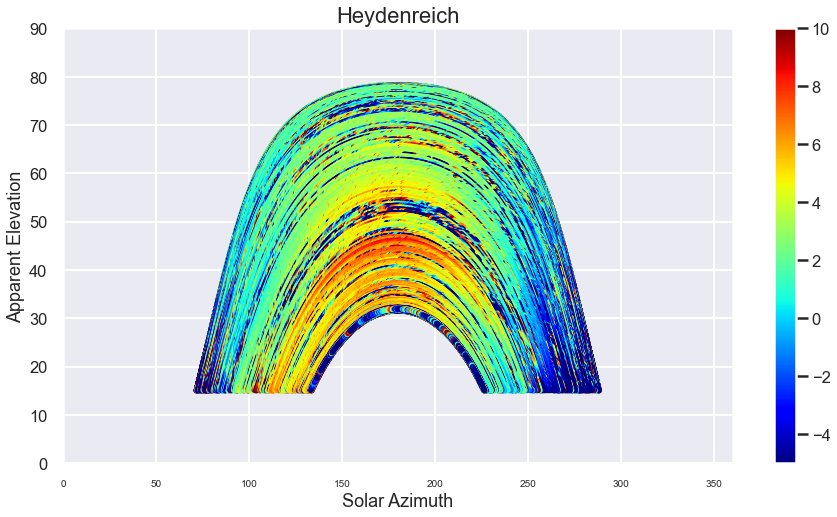

In [234]:
plt.scatter(x=results_df['Sol Azim'], y=results_df['Sol Elev'], c=results_df['Dpmp_%'], cmap='jet', s=10)
plt.colorbar()
plt.clim(-5,10)
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation')
plt.xlabel('Solar Azimuth')
plt.title('Heydenreich')

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_19472\1524718128.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0.5, 1.0, 'Heydenreich')

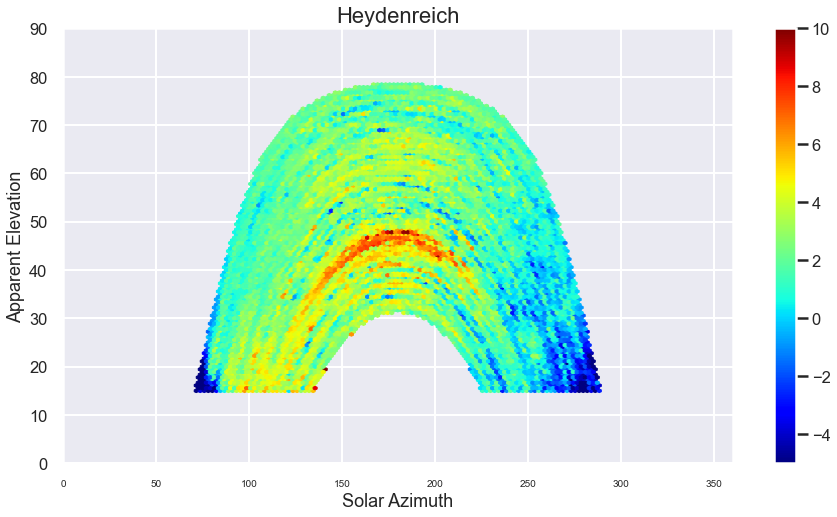

In [225]:
plt.hexbin(x=results_df['Sol Azim'], y=results_df['Sol Elev'], C=results_df['Dpmp_%'], bins=None, cmap='jet')
plt.colorbar()
plt.clim(-5,10)
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation')
plt.xlabel('Solar Azimuth')
plt.title('Heydenreich')

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_19472\2568649010.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0.5, 0, 'Solar Azimuth')

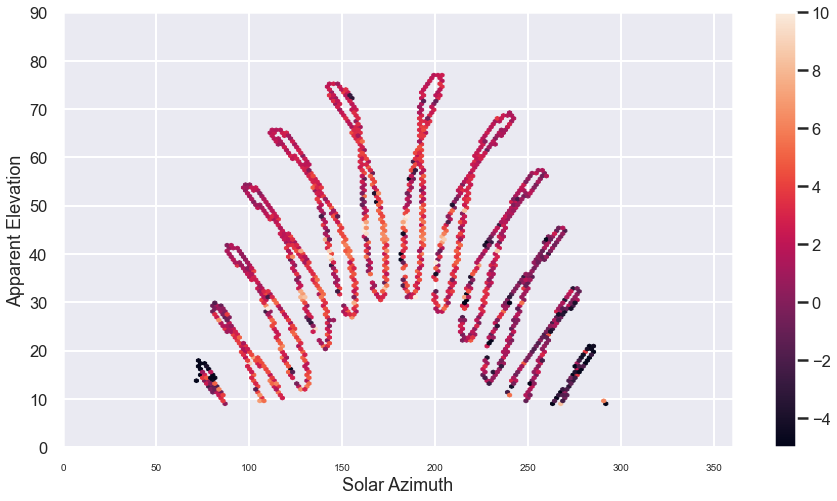

In [236]:
plt.hexbin(x=results_hour['Sol Azim'], y=results_hour['Sol Elev'], C=results_hour['Dpmp_%'], bins=None)
plt.colorbar()
plt.clim(-5,10)
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation')
plt.xlabel('Solar Azimuth')

C:\Users\lmdevil\AppData\Local\Temp\ipykernel_19472\898512591.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0.5, 1.0, 'Heydenreich')

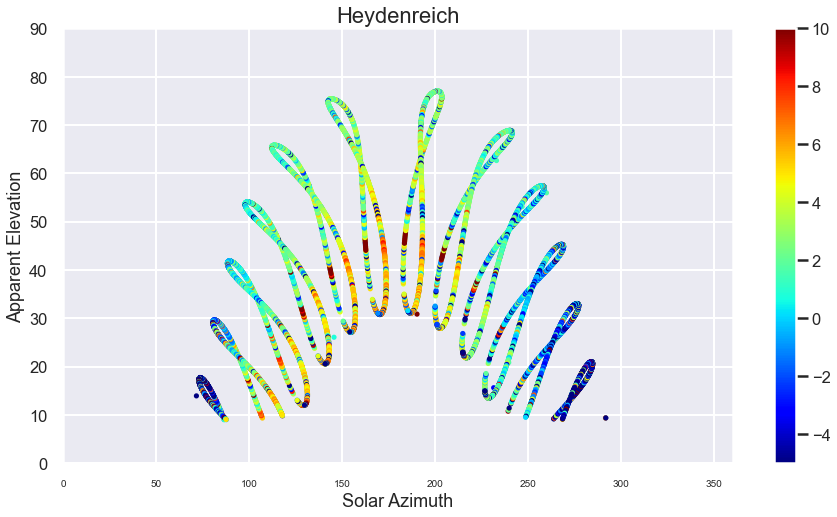

In [235]:
plt.scatter(x=results_hour['Sol Azim'], y=results_hour['Sol Elev'], c=results_hour['Dpmp_%'], cmap='jet', s=10)
plt.colorbar()
plt.clim(-5,10)
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation')
plt.xlabel('Solar Azimuth')
plt.title('Heydenreich')